In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

In [2]:
# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

In [3]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

In [9]:
from PIL import Image
style.use('default')

image_size = 128      # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('pic1.jpeg'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)

Raw Image info: (960, 1280, 3)
Raw Image datatype: uint8


Image shape (numpy array): (128, 128)


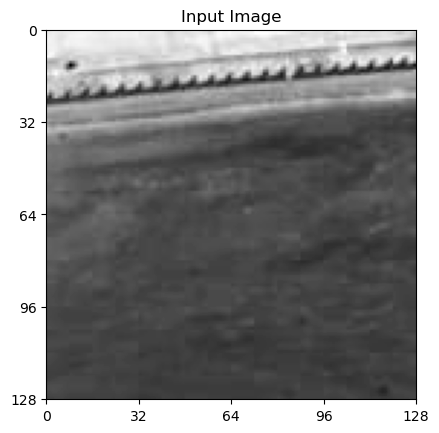

In [10]:
# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


plt.title('Input Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='gray_r')
plt.show()

In [11]:
# Initialize some global variable for number of qubits
data_qb = 10
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [13]:
new_image = image
for i in range (0, 128, 32):
    print(i)
    for j in range (0, 128, 32):
        image1 = image[i:i+32, j:j+32]
        image1_norm_h = amplitude_encode(image1)
        image1_norm_v = amplitude_encode(image1.T)
        # Create the circuit for horizontal scan
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image1_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)
        # display(qc_h.draw('mpl', fold=-1))

        # Create the circuit for vertical scan
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image1_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)
        # display(qc_v.draw('mpl', fold=-1))

        # Combine both circuits into a single list
        circ_list = [qc_h, qc_v]
        
        # Simulating the cirucits
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)
        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

        # Selecting odd states from the raw statevector and
        # reshaping column vector of size 64 to an 8x8 matrix
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(32, 32).T
        
        edge_scan_sim = edge_scan_h | edge_scan_v
        
        for a in range (32):
            for b in range (32):
                new_image[i+a][j+b]=edge_scan_sim[a][b]

0
32
64
96


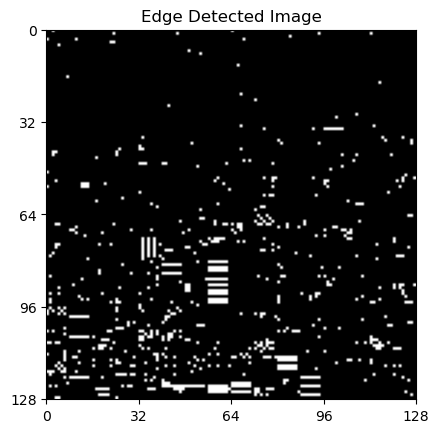

(128, 128)


In [14]:
plt.title('Edge Detected Image')
plt.xticks(range(0, new_image.shape[0]+1, 32))
plt.yticks(range(0, new_image.shape[1]+1, 32))
plt.imshow(new_image, extent=[0, new_image.shape[0], new_image.shape[1], 0], cmap='gray_r')
plt.show()
print(new_image.shape)